In [1]:
import matplotlib.pyplot as plt

def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
                   use_random_iter=False):
    # 创建两个列表跟踪每个epoch的困惑度 用于绘图
    epochs = []
    ppls = []

    # 使用交叉熵损失进行处理
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(model, nn.Module):
        # PyTorch模型：使用标准SGD优化器
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        # 自定义模型：使用函数式SGD实现
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)

    # 预测函数
    def predict(prefix):
        return d2l.predict_ch8(prefix, 50, model, vocab, device)

    # 训练循环
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        # 更新列表中的轮次以及困惑度
        epochs.append(epoch + 1)
        ppls.append(ppl)

    # 训练完成后打印最终结果
    print(f'训练完成。最终困惑度: {ppl:.2f}, 速度: {speed:.1f} tokens/sec on {str(device)}')
    print('生成文本示例:')
    print(predict('time traveller'))

    # 训练完成后绘制困惑度曲线
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, ppls, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

训练完成。最终困惑度: 1.09, 速度: 489310.0 tokens/sec on cuda:0
生成文本示例:
time travellerererererererererererererererererererererererererer


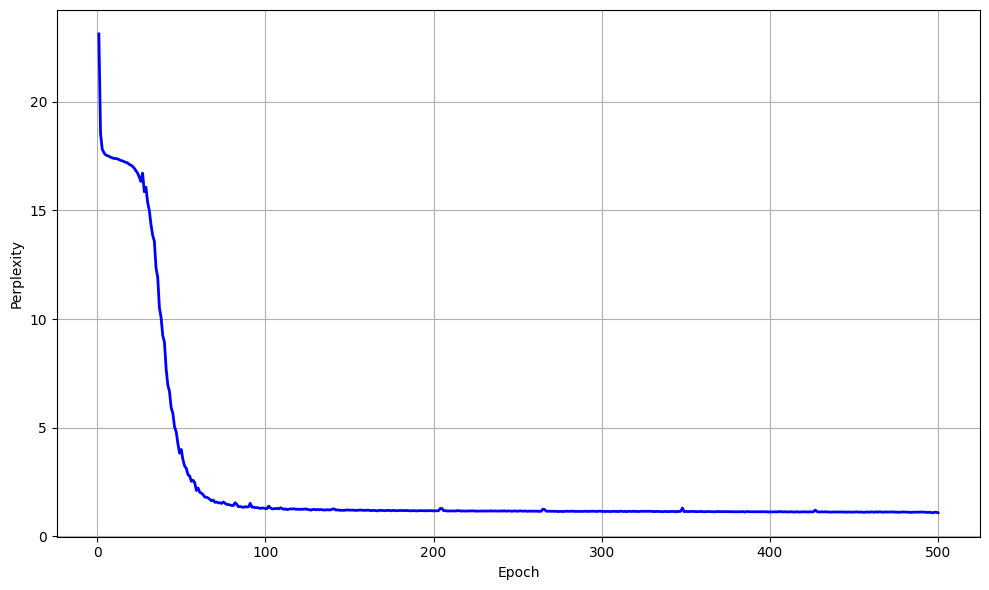

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 双向LSTM的公式与计算过程详解

本文详细解析了双向LSTM模型的核心公式与计算过程，帮助理解其在时间序列任务中的工作机制。

---

## 参数上下文

假设以下参数：
- **`batch_size`**: 每个批次的样本数量，设定为 `32`。
- **`num_steps`**: 序列的时间步数，设定为 `35`。
- **`num_inputs`**: 每个时间步输入的特征维度，等于词汇量大小 `vocab_size`。
- **`num_hiddens`**: 每个LSTM单元的隐藏状态维度，设定为 `256`。
- **`num_layers`**: 隐藏层的数量，设定为 `2`。
- **`bidirectional=True`**: 双向LSTM，正向和反向同时计算。

---

## 双向LSTM的核心公式与计算过程

双向LSTM将每个时间步的输入序列同时传递给正向LSTM和反向LSTM，并通过拼接两个LSTM的隐藏状态输出得到最终结果。

### 1. 正向LSTM公式
正向LSTM从时间步 $t=1$ 到 $t=T$ 按以下公式计算：
$$
\begin{aligned}
& i_t^{(f)} = \sigma(X_t W_{xi}^{(f)} + H_{t-1}^{(f)} W_{hi}^{(f)} + b_i^{(f)}) \\
& f_t^{(f)} = \sigma(X_t W_{xf}^{(f)} + H_{t-1}^{(f)} W_{hf}^{(f)} + b_f^{(f)}) \\
& o_t^{(f)} = \sigma(X_t W_{xo}^{(f)} + H_{t-1}^{(f)} W_{ho}^{(f)} + b_o^{(f)}) \\
& \tilde{C}_t^{(f)} = \tanh(X_t W_{xc}^{(f)} + H_{t-1}^{(f)} W_{hc}^{(f)} + b_c^{(f)}) \\
& C_t^{(f)} = f_t^{(f)} \odot C_{t-1}^{(f)} + i_t^{(f)} \odot \tilde{C}_t^{(f)} \\
& H_t^{(f)} = o_t^{(f)} \odot \tanh(C_t^{(f)})
\end{aligned}
$$

- **$i_t^{(f)}$**: 输入门，控制当前输入写入记忆单元的比例。
- **$f_t^{(f)}$**: 遗忘门，控制前一时间步记忆的保留比例。
- **$o_t^{(f)}$**: 输出门，控制记忆单元输出到隐藏状态的比例。
- **$\tilde{C}_t^{(f)}$**: 候选记忆单元，当前时间步的新信息。
- **$C_t^{(f)}$**: 正向LSTM的记忆单元。
- **$H_t^{(f)}$**: 正向LSTM的隐藏状态。

---

### 2. 反向LSTM公式
反向LSTM从时间步 $t=T$ 到 $t=1$ 按以下公式计算：
$$
\begin{aligned}
& i_t^{(b)} = \sigma(X_t W_{xi}^{(b)} + H_{t+1}^{(b)} W_{hi}^{(b)} + b_i^{(b)}) \\
& f_t^{(b)} = \sigma(X_t W_{xf}^{(b)} + H_{t+1}^{(b)} W_{hf}^{(b)} + b_f^{(b)}) \\
& o_t^{(b)} = \sigma(X_t W_{xo}^{(b)} + H_{t+1}^{(b)} W_{ho}^{(b)} + b_o^{(b)}) \\
& \tilde{C}_t^{(b)} = \tanh(X_t W_{xc}^{(b)} + H_{t+1}^{(b)} W_{hc}^{(b)} + b_c^{(b)}) \\
& C_t^{(b)} = f_t^{(b)} \odot C_{t+1}^{(b)} + i_t^{(b)} \odot \tilde{C}_t^{(b)} \\
& H_t^{(b)} = o_t^{(b)} \odot \tanh(C_t^{(b)})
\end{aligned}
$$

- 正向LSTM和反向LSTM的公式类似，唯一的区别是反向LSTM的计算顺序是从时间步 $t=T$ 到 $t=1$。

---

### 3. 双向LSTM的输出
正向LSTM和反向LSTM的隐藏状态拼接为双向LSTM的输出：
$$
H_t = [H_t^{(f)}; H_t^{(b)}]
$$
- **$H_t$**: 双向LSTM的隐藏状态，维度为 $[2 \times \text{num\_hiddens}]$。
- 具体来说，如果正向和反向的隐藏状态维度均为 $256$，则拼接后的维度为 $512$。

---

### 4. 输出层
双向LSTM的隐藏状态经过全连接层生成每个时间步的输出：
$$
Y_t = H_t W_{hq} + b_q
$$
- **$Y_t$**: 当前时间步的输出，维度为 `[vocab_size]`，表示预测的下一个词的概率分布。
- **$W_{hq}$**: 输出层的权重矩阵，形状为 $[512, \text{vocab\_size}]$。
- **$b_q$**: 输出层的偏置向量，形状为 $[\text{vocab\_size}]$。
